# Tutorial on Intrinsic dimension estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dadapy import data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:

# import a test set
X = np.random.multivariate_normal([0, 0], [[1, 0.9999],[ 0.9999, 1]], size = (2000,))


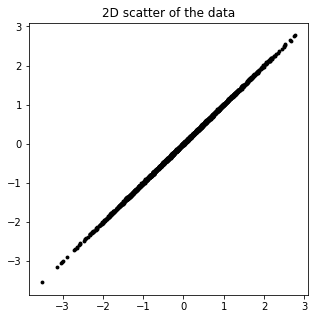

In [3]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

## TwoNN estimator

In [ ]:
# initialise the Data class
_data = data.Data(X)

In [14]:
# estimate ID
_data.compute_id_2NN()


Computation of distances started
Computation of the distances up to 100 NNs started
0.03 seconds for computing distances
ID estimation finished: selecting ID of 1.887440728230349


(1.887440728230349, 0.0, 0.008036673399811714)

In [7]:
 ids_scaling, ids_scaling_std, r2s_scaling = _data.return_id_scaling_2NN(N_min = 10)

ID estimation finished: selecting ID of 1.887440728230349
ID estimation finished: selecting ID of 1.8946348516702387
ID estimation finished: selecting ID of 1.79357796826099
ID estimation finished: selecting ID of 1.749879159738871
ID estimation finished: selecting ID of 1.509186756570717
ID estimation finished: selecting ID of 1.3388850778050194
ID estimation finished: selecting ID of 1.2337483293703146
ID estimation finished: selecting ID of 1.2018811480750822


<ErrorbarContainer object of 3 artists>

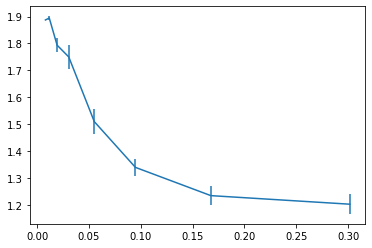

In [8]:
plt.errorbar(r2s_scaling, ids_scaling, ids_scaling_std)

## Gride estimator

In [26]:
# initialise the Data class
_data = data.Data(X, maxk = X.shape[0] -1)

In [36]:
#ids_scaling, ids_scaling_std, r2s_scaling = _data.return_id_scaling_gride(range_max=1000)

In [35]:
#print(ids_scaling.shape, r2s_scaling.shape)

In [34]:
#plt.errorbar(r2s_scaling, ids_scaling, ids_scaling_std)